In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [0]:
!pip install -U tensorflow
!pip install -U keras
clear_output()

In [0]:
!pip install pycodestyle flake8 pycodestyle_magic
%load_ext pycodestyle_magic
clear_output()

In [0]:
!chmod 600 kaggle.json

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c kuzushiji-recognition
clear_output()

In [0]:
!mkdir train_images
!mkdir test_images

In [0]:
!unzip train_images.zip -d train_images
!unzip test_images.zip -d test_images
!unzip train.csv.zip
!rm train_images.zip
!rm test_images.zip
!rm train.csv.zip
clear_output()

#Data
Source: https://www.kaggle.com/c/kuzushiji-recognition/ <br>
Kuzushiji is an ancient Japanese cursive script. The goal is to locate and classify each kuzushiji character on each image in the test set. <br>
Train set size: 3881 images. <br>
Test set size: 4150 images. <br>
**train.csv** contains labels for each kuzushiji character in the train set. Train.csv columns:
*   **image_id** – ID code for the image.
*   **labels** – string with labels for all kuzushiji characters on the image, separated by space. Each label is a space-separated series of values (Unicode char, X, Y, width and height) of the character.

Predictions for the test set should have the following format:
*   **image_id**
*    **labels**, formatted like (Unicode char, X, Y). Width and height don't need to be predicted.

Predictions will be evaluated on F1-score. In this version of the metric, a correct (i. e., true positive) prediction is made when the character is correct and X and Y coordinates are within the ground truth bounding box. The ground truth bounding boxes are defined in the format {Unicode char X Y Width Height}, so if the ground truth label is U+003F 1 1 10 10 then a prediction of U+003F 3 3 would pass. <br>
Mapping between Japanese characters and corresponding Unicode IDs is stored in the file **unicode_translation.csv**. <br>
Notes about the data:
*   Some images don't contain kuzushiji characters.
*   Kuzushiji text is written such that annotations are placed between the columns of the main text, usually in a slightly smaller font. Annotation characters should be ignored.
*   You can occasionally see through especially thin paper and read characters from the opposite side of the page. Those characters should also be ignored.


In [0]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
from keras import layers as L
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from warnings import filterwarnings
%matplotlib inline
filterwarnings("ignore")
clear_output()

In [0]:
df_train = pd.read_csv("train.csv")

In [12]:
df_train.shape

(3881, 2)

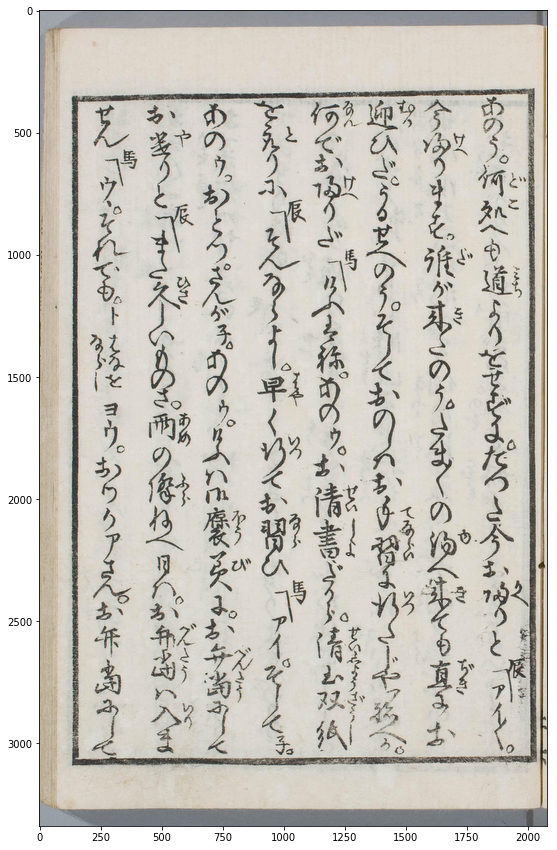

In [13]:
# example image
plt.figure(figsize=(15, 15))
img = np.asarray(Image.open(
    f"train_images/{df_train.values[np.random.randint(len(df_train))][0]}.jpg"
).convert("RGBA"))
plt.imshow(img, interpolation="lanczos")
plt.show()

In [14]:
# labels for the train set
df_train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [0]:
unicode_translation = pd.read_csv("unicode_translation.csv")

In [16]:
unicode_translation.head(n=10)

,Unicode,char
0,U+0031,1
1,U+0032,2
2,U+0034,4
3,U+0036,6
4,U+0039,9
5,U+003F,?
6,U+2000B,𠀋
7,U+20D45,𠵅
8,U+2123D,𡈽
9,U+22999,𢦙


In [0]:
# store mapping in dictionary
mapping = dict()
for i in range(len(unicode_translation.index)):
    mapping[unicode_translation["Unicode"][i]] = unicode_translation["char"][i]

In [0]:
sample_submission = pd.read_csv("sample_submission.csv")

In [19]:
# a sample submission in the correct format
sample_submission.head()

,image_id,labels
0,test_00145af3,U+003F 1 1 U+FF2F 2 2
1,test_001c37e2,U+003F 1 1 U+FF2F 2 2
2,test_003aa33a,U+003F 1 1 U+FF2F 2 2
3,test_00665e33,U+003F 1 1 U+FF2F 2 2
4,test_006964dc,U+003F 1 1 U+FF2F 2 2


In [20]:
# removing rows contains NaN
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)
df_train.shape

(3605, 2)

#Data visualisation
Source: https://www.kaggle.com/anokas/kuzushiji-visualisation <br>
A function below prints an image with labels and bounding boxes for all recognized on that image characters.



In [0]:
!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
!rm NotoSansCJKjp-hinted.zip
clear_output()

In [0]:
fontsize = 50
font = ImageFont.truetype("./NotoSansCJKjp-Regular.otf",
                          fontsize, encoding="utf-8")

In [0]:
def visualize_training_data(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 5)

    # Read image
    imsource = Image.open(image_fn).convert("RGBA")
    bbox_canvas = Image.new("RGBA", imsource.size)
    char_canvas = Image.new("RGBA", imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas)
    # Separate canvases for boxes and chars
    # so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        char = mapping[codepoint]
        # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h),
                            fill=(255, 255, 255, 0),
                            outline=(255, 0, 0, 255))
        char_draw.text((x + w + fontsize/4, y + h/2 - fontsize),
                       char, fill=(0, 0, 255, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource,
                                                           bbox_canvas),
                                     char_canvas)
    imsource = imsource.convert("RGB")
    # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

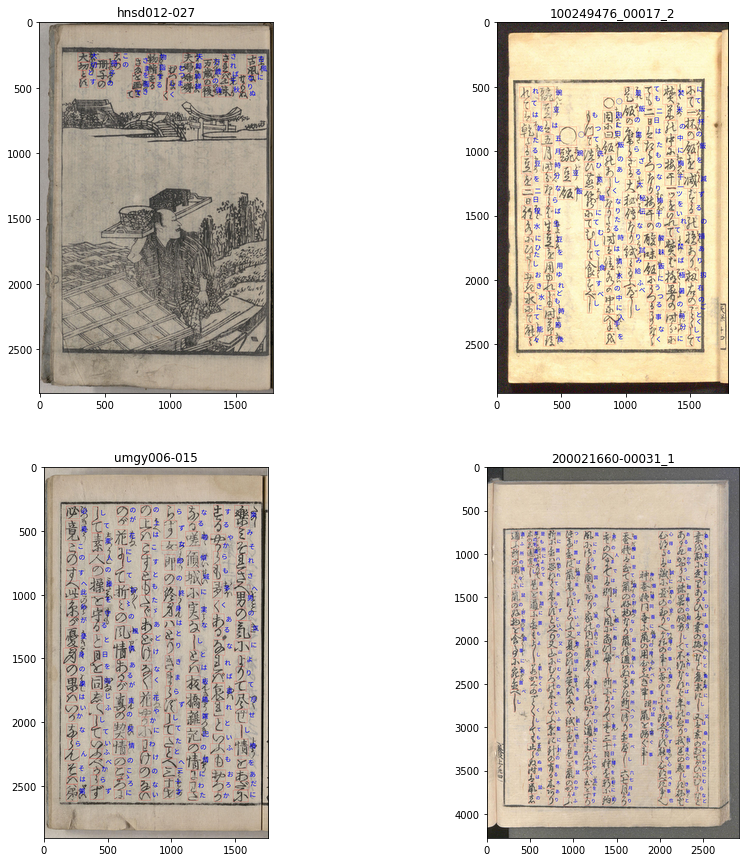

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for i in range(2):
    for j in range(2):
        img, labels = df_train.values[np.random.randint(len(df_train))]
        viz = visualize_training_data(f"train_images/{img}.jpg", labels)
        ax[i, j].imshow(viz, interpolation="lanczos")
        ax[i, j].set_title(img)

plt.show()

A similar function, but for predictions. It prints only predicted labels, without bounding boxes.

In [0]:
def visualize_predictions(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 3)

    # Read image
    imsource = Image.open(image_fn).convert("RGBA")
    bbox_canvas = Image.new("RGBA", imsource.size)
    char_canvas = Image.new("RGBA", imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas)
    # Separate canvases for boxes and chars
    # so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y in labels:
        x, y = int(x), int(y)
        char = mapping[codepoint]
        # Convert codepoint to actual unicode character

        # Draw bounding box around character,
        # and unicode character next to it
        bbox_draw.rectangle((x - 10, y - 10, x + 10, y + 10),
                            fill=(255, 0, 0, 255))
        char_draw.text((x + 25, y - fontsize * (3 / 4)),
                       char, fill=(255, 0, 0, 255), font=font)

    imsource = Image.alpha_composite(
        Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB")
    # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

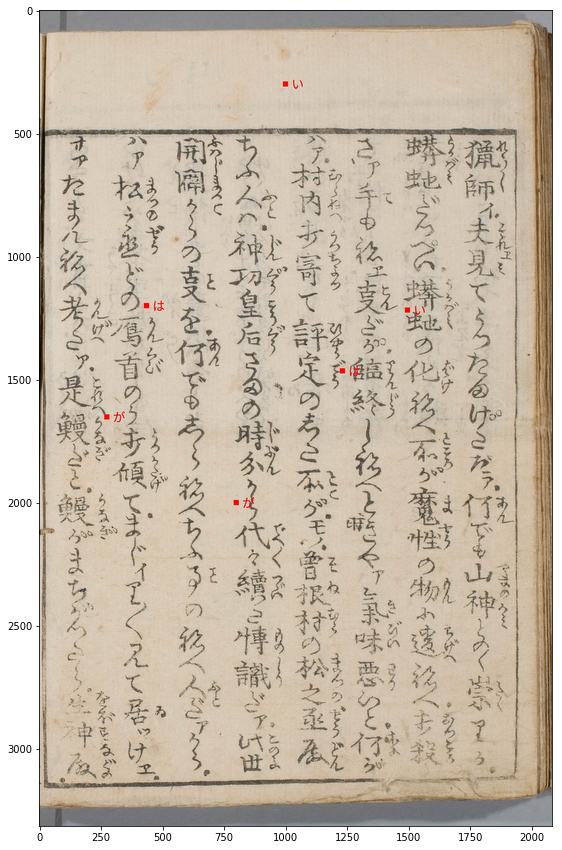

In [26]:
img = df_train.values[np.random.randint(len(df_train))][0]
# just some random prediction string
example_pred = "U+306F 1231 1465 U+304C 275 1652 U+3044 \
1495 1218 U+306F 436 1200 U+304C 800 2000 U+3044 1000 300"
viz = visualize_predictions(f"train_images/{img}.jpg", example_pred)
plt.figure(figsize=(15, 15))
plt.imshow(viz, interpolation="lanczos")
plt.show()

#Data preprocessing

In [0]:
idx = {unicode_translation["Unicode"][i]: i for i in range(len(unicode_translation))}
inv_idx = {val: key for key, val in idx.items()}

In [0]:
data = []
for i in range(len(df_train)):
    img = df_train["image_id"][i]
    labels = np.array(df_train.loc[i, "labels"].split(" ")).reshape(-1, 5)
    for j, label in enumerate(labels[:, 0]):
        labels[j, 0] = idx[label]  
    labels = labels.astype('int32')
    labels[:, 1] += labels[:, 3] // 2 # center_x
    labels[:, 2] += labels [:, 4] // 2 # center_y
    data.append([f"train_images/{img}.jpg", labels])

In [0]:
data_train, data_cv = train_test_split(data, test_size = 0.2)

# Approach 1: CenterNet Keypoint Detector + random cropping + CNN for claccification
Source: https://www.kaggle.com/kmat2019/centernet-keypoint-detector <br>
Paper on CenterNet: https://arxiv.org/abs/1904.07850

## Data generator

In [0]:
label_n = 1
output_layer_n = label_n + 4
output_height, output_width = 128, 128


def data_generator(filenames, batch_size):
    X = []
    y = []
    count = 0
    while True:
        for i in range(len(filenames)):
            crop_ratio = np.random.uniform(0.5, 1)
            with Image.open(filenames[i][0]) as file:
                pic_width, pic_height = file.size
                file = np.asarray(file.convert("RGBA"), dtype=np.uint8)
                top_offset = np.random.randint(0, pic_height -
                                               int(crop_ratio * pic_height))
                left_offset = np.random.randint(0, pic_width -
                                                int(crop_ratio_w * pic_width))
                bottom_offset = top_offset + int(crop_ratio * pic_height)
                right_offset = left_offset + int(crop_ratio * pic_width)
                file = cv2.resize(file[top_offset: bottom_offset,
                                       left_offset: right_offset, :],
                                  (input_height, input_width))
                X.append(file)

            output_layer = np.zeros((output_height, output_width,
                                     (output_layer_n + label_n)))
            for label in filenames[i][1]:
                x_c = (label[1] - left_offset) * \
                (output_width / int(crop_ratio * pic_width))
                y_c = (label[2] - top_offset) * \
                (output_height / int(crop_ratio * pic_height))
                width = label[3] * (output_width / int(crop_ratio * pic_width))
                height = label[4] * (output_height /
                                     int(crop_ratio * pic_height))
                top = np.maximum(0, y_c - height / 2)
                left = np.maximum(0, x_c - width / 2)
                bottom = np.minimum(output_height, y_c + height / 2)
                right = np.minimum(output_width, x_c + width / 2)

            if top >= (output_height - 0.1) or \
                    left >= (output_width - 0.1) or \
                    bottom <= 0.1 or right <= 0.1:
                continue
            width = right - left
            height = bottom - top
            x_c = (right + left) / 2
            y_c = (top + bottom) / 2

            label = 0
            heatmap = ((np.exp(-(((np.arange(output_width) - x_c) /
                                  (width / 10)) ** 2) / 2)).reshape(1, -1) * \
                       (np.exp(-(((np.arange(output_height) - y_c) /
                                  (height / 10)) ** 2) / 2)).reshape(-1, 1))
            output_layer[:, :, label] = np.maximum(output_layer[:, :, label],
                                                   heatmap[:, :])
            output_layer[int(y_c // 1), int(x_c // 1), label_n + label] = 1
            output_layer[int(y_c // 1), int(x_c // 1), 2 * label_n] = y_c % 1
            output_layer[int(y_c // 1), int(x_c // 1),
                         2 * label_n + 1] = x_c % 1
            output_layer[int(y_c // 1), int(x_c // 1),
                         2 * label_n + 2] = height / output_height
            output_layer[int(y_c // 1), int(x_c // 1),
                         2 * label_n + 3] = width / output_width
            y.append(output_layer)

            count += 1
            if count == batch_size:
                X = np.array(X, dtype=np.float32)
                y = np.array(y, dtype=np.float32)

            inputs = X / 255
            targets = y
            X = []
            y = []
            count = 0
    yield inputs, targets

##Loss functions

In [0]:
def all_loss(y_true, y_pred):
    mask = K.sign(y_true[..., 2 * layer_n + 2])
    N = K.sum(mask)
    alpha = 2.
    beta = 4.

    heatmap_true_rate = K.flatten(y_true[..., :label_n])
    heatmap_true = K.flatten(y_true[..., label_n: (2 * label_n)])
    heatmap_pred = K.flatten(y_pred[..., :label_n])
    heatloss = -K.sum(heatmap_true * ((1 - heatmap_pred) ** alpha) * \
                      K.log(heatmap_pred + 1e-6) + (1 - heatmap_true) * \
                      ((1 - heatmap_true_rate) ** beta) * \
                      (heatmap_pred ** alpha) * \
                      K.log(1 - heatmap_pred + 1e-6))
    offsetloss = K.sum(K.abs(y_true[..., 2 * label_n] - \
                             y_pred[..., label_n] * mask) + \
                       K.abs(y_true[..., 2 * label_n + 1] - \
                             y_pred[..., label_n + 1] * mask))
    sizeloss = K.sum(K.abs(y_true[..., 2 * label_n + 2] - \
                           y_pred[..., label_n + 2] * mask) + \
                     K.abs(y_true[..., 2 * label_n + 3] - \
                           y_pred[..., label_n + 3] * mask))

    all_loss = (heatloss + 1.0 * offsetloss + 5.0 * sizeloss) / N
    return all_loss

In [0]:
def size_loss(y_true, y_pred):
    mask = K.sign(y_true[..., 2 * label_n + 2])
    N = K.sum(mask)
    sizeloss = K.sum(K.abs(y_true[..., 2 * label_n + 2] - \
                           y_pred[..., label_n + 2] * mask) + \
                     K.abs(y_true[..., 2 * label_n + 3] - \
                           y_pred[..., label_n + 3] * mask))
    return (5 * sizeloss) / N

In [0]:
def offset_loss(y_true, y_pred):
    mask = K.sign(y_true[..., 2 * label_n + 2])
    N = K.sum(mask)
    offsetloss = K.sum(K.abs(y_true[..., 2 * label_n] - \
                             y_pred[..., label_n] * mask) + \
                       K.abs(y_true[..., 2 * label_n + 1] - \
                             y_pred[..., label_n + 1] * mask))
    return (offsetloss) / N

In [0]:
def heatmap_loss(y_true, y_pred):
    mask = K.sign(y_true[..., 2 * label_n + 2])
    N = K.sum(mask)
    alpha = 2.
    beta = 4.

    heatmap_true_rate = K.flatten(y_true[..., :label_n])
    heatmap_true = K.flatten(y_true[..., label_n:(2 * label_n)])
    heatmap_pred = K.flatten(y_pred[..., :label_n])
    heatloss = -K.sum(heatmap_true * ((1 - heatmap_pred) ** alpha) * \
                      K.log(heatmap_pred + 1e-6) + (1 - heatmap_true) \
                      * ((1 - heatmap_true_rate) ** beta) * \
                      (heatmap_pred ** alpha) * K.log(1 - heatmap_pred + 1e-6))
    return heatloss / N

##Model

In [0]:
def aggregation_block(x_shallow, x_deep, deep_ch, out_ch):
    x_deep = L.Conv2DTranspose(deep_ch, kernel_size=2,
                             strides=2, padding='same', use_bias=False)(x_deep)
    x_deep = L.BatchNormalization()(x_deep)
    x_deep = L.LeakyReLU(alpha=0.1)(x_deep)
    x = L.Concatenate()([x_shallow, x_deep])
    x = L.Conv2D(out_ch, kernel_size=1, strides=1, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.LeakyReLU(alpha=0.1)(x)
    return x


def cbr(x, out_layer, kernel, stride):
    x = L.Conv2D(out_layer, kernel_size=kernel,
               strides=stride, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.LeakyReLU(alpha=0.1)(x)
    return x


def resblock(x_in, layer_n):
    x = cbr(x_in, layer_n, 3, 1)
    x = cbr(x, layer_n, 3, 1)
    x = L.Add()([x, x_in])
    return x

In [0]:
def create_model(input_shape, aggregation=True):
    input_layer = L.Input(input_shape)

    input_layer_1 = L.AveragePooling2D(2)(input_layer)
    input_layer_2 = L.AveragePooling2D(2)(input_layer_1)

    x_0 = cbr(input_layer, 16, 3, 2)
    concat_1 = L.Concatenate()([x_0, input_layer_1])

    x_1 = cbr(concat_1, 32, 3, 2)
    concat_2 = L.Concatenate()([x_1, input_layer_2])

    x_2 = cbr(concat_2, 64, 3, 2)

    x = cbr(x_2, 64, 3, 1)
    x = resblock(x, 64)
    x = resblock(x, 64)

    x_3 = cbr(x, 128, 3, 2)
    x = cbr(x_3, 128, 3, 1)
    x = resblock(x, 128)
    x = resblock(x, 128)
    x = resblock(x, 128)

    x_4 = cbr(x, 256, 3, 2)
    x = cbr(x_4, 256, 3, 1)
    x = resblock(x, 256)
    x = resblock(x, 256)
    x = resblock(x, 256)
    x = resblock(x, 256)
    x = resblock(x, 256)

    x_5 = cbr(x, 512, 3, 2)
    x = cbr(x_5, 512, 3, 1)

    x = resblock(x, 512)
    x = resblock(x, 512)
    x = resblock(x, 512)

    x_1 = cbr(x_1, output_layer_n, 1, 1)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
    x_2 = cbr(x_2, output_layer_n, 1, 1)
    x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
    x_3 = cbr(x_3, output_layer_n, 1, 1)
    x_3 = aggregation_block(x_3, x_4, output_layer_n, output_layer_n)
    x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)

    x_4 = cbr(x_4, output_layer_n, 1, 1)

    x = cbr(x, output_layer_n, 1, 1)
    x = L.UpSampling2D(size=(2, 2))(x)

    x = L.Concatenate()([x, x_4])
    x = cbr(x, output_layer_n, 3, 1)
    x = L.UpSampling2D(size=(2, 2))(x)

    x = L.Concatenate()([x, x_3])
    x = cbr(x, output_layer_n, 3, 1)
    x = L.UpSampling2D(size=(2, 2))(x)

    x = L.Concatenate()([x, x_2])
    x = cbr(x, output_layer_n, 3, 1)
    x = L.UpSampling2D(size=(2, 2))(x)

    x = L.Concatenate()([x, x_1])
    x = L.Conv2D(output_layer_n, kernel_size=3, strides=1, padding="same")(x)
    out = L.Activation("sigmoid")(x)

    model = Model(input_layer, out)

    return model

##Training

In [0]:
def model_fit_centernet(model, data_train, data_cv, n_epoch, batch_size=32):
    hist = model.fit_generator(
        data_generator(data_train, batch_size),
        steps_per_epoch=len(data_train) // batch_size,
        epochs=n_epoch,
        validation_data=data_generator(data_cv, batch_size),
        validation_steps=len(data_cv) // batch_size,
        callbacks=[lr_schedule],
        shuffle=True,
        verbose=1
    )
    return hist

In [0]:
input_height, input_width = 512, 512

K.clear_session()
model = create_model(input_shape=(input_height, input_width, 3))


def lrs(epoch):
    lr = 0.001
    if epoch >= 20:
        lr = 0.0002
    return lr


lr_schedule = LearningRateScheduler(lrs)
clear_output()